In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

## 1. Leer la imagen

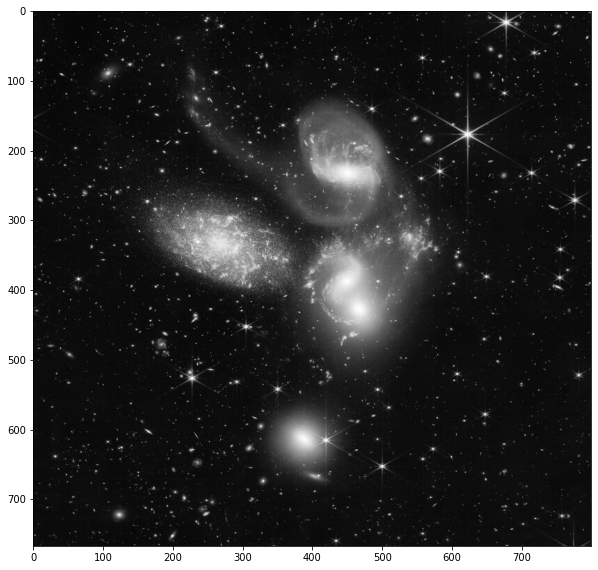

In [6]:
# leer imagen
img = cv2.imread('../imagenes/james_webb_3.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')

## 2. Filtro gaussiano de ruido

In [7]:
def convolutional_filter(imagen, kernel):
    alto = imagen.shape[0]
    ancho = imagen.shape[1]

    altoKernel = len(kernel[:,0])
    anchoKernel = len(kernel[0,:])

    #parte entera del centro del kernel
    step = int(len(kernel[0,:])/2)

    newImg = np.zeros((alto, ancho, 1))

    for i in range(step, alto - step):
        newPixel = 0
        for j in range(step, ancho - step):
            ventana = imagen[i-step:i+2*step, j-step:j+2*step]
            newPixel = 0
            for m in range(0, altoKernel):
                for n in range(0, anchoKernel):
                    newPixel = newPixel + ventana[m, n] * kernel[m, n]
            newImg[i, j] = int(newPixel)

    return newImg 

## 3. Derivada en X

In [20]:
def derivada_x(img):
    alto = img.shape[0]
    ancho = img.shape[1]

    derivada = np.zeros((alto, ancho, 1))
    kernel = np.array([[1/16, 2/16, 1/16],[2/16, 4/16, 2/16],[1/16, 2/16, 1/16]])
    img2 = convolutional_filter(img, kernel)

    for i in range(0, alto):
        for j in range(0, ancho - 1):
            derivada[i, j] = img2[i, j+1] - img2[i, j]

    return derivada



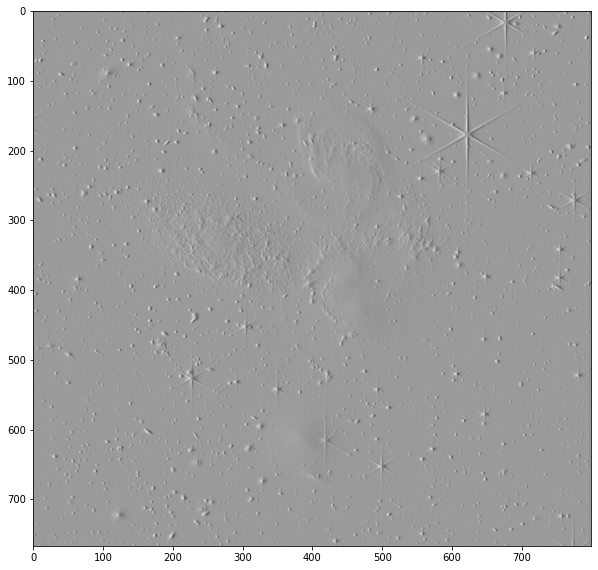

In [17]:
img_derivada_x = derivada_x(img)


plt.figure(figsize=(10, 10))
plt.imshow(img_derivada_x, cmap='gray')

## 4. Derivada en Y

In [19]:
def derivada_y(img):
    alto = img.shape[0]
    ancho = img.shape[1]

    derivada = np.zeros((alto, ancho, 1))
    kernel = np.array([[1/16, 2/16, 1/16],[2/16, 4/16, 2/16],[1/16, 2/16, 1/16]])
    img2 = convolutional_filter(img, kernel)

    for i in range(0, alto-1):
        for j in range(0, ancho):
            derivada[i, j] = img2[i+1, j] - img2[i, j]

    return derivada


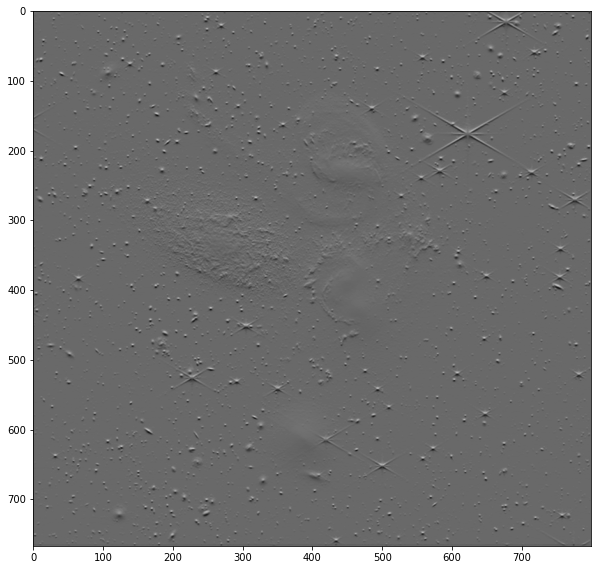

In [22]:
img_derivada_y = derivada_y(img)


plt.figure(figsize=(10, 10))
plt.imshow(img_derivada_y, cmap='gray')

## 5. Magnitud

In [23]:
def magnitud(dx, dy):
    alto = dx.shape[0]
    ancho = dx.shape[1]
    salida = np.zeros((alto, ancho, 1))

    for i in range(0, alto):
        for j in range(0, ancho):
            salida[i, j] = np.sqrt(dx[i, j]**2 + dy[i, j]**2)

    return salida


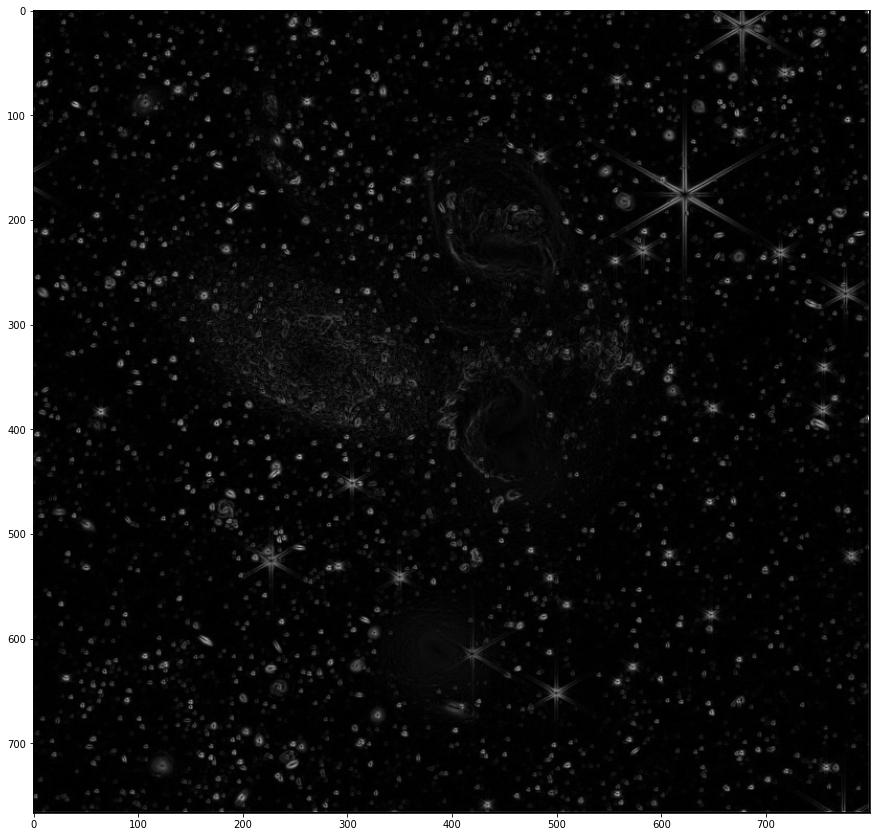

In [25]:
magnitud_img = magnitud(img_derivada_x, img_derivada_y)

plt.figure(figsize=(15, 15))
plt.imshow(magnitud_img, cmap='gray')

## 6. Fase

In [28]:
def fase(dx, dy):
    alto = dx.shape[0]
    ancho = dx.shape[1]
    salida = np.zeros((alto, ancho, 1))

    for i in range(0, alto):
        for j in range(0, ancho):
            salida[i, j] = int((180/math.pi)*(math.atan2(dy[i,j], dx[i,j])))

    return salida

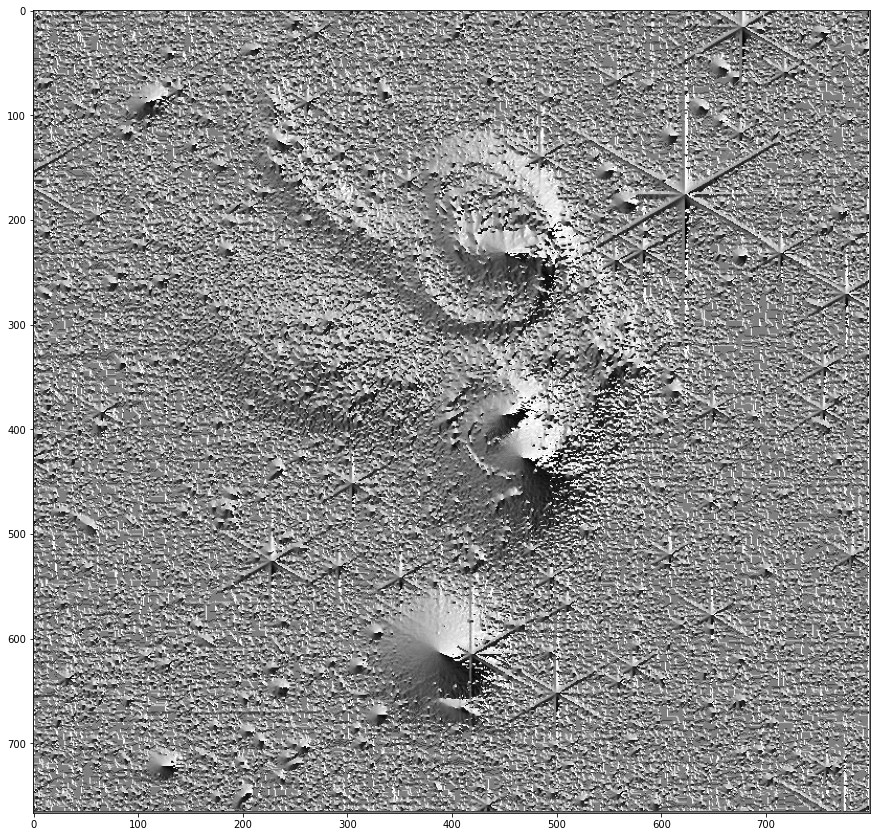

In [33]:
fase_img = fase(img_derivada_x, img_derivada_y)

plt.figure(figsize=(15, 15))
plt.imshow(fase_img, cmap='gray')

## 7. NMS

In [30]:
def non_maximum_suppression(magImage, phaseImage):
    alto = magImage.shape[0]
    ancho =  magImage.shape[1]
      
    newImg = np.zeros((alto, ancho,1))
    val1 = 0
    val2 = 0
    val3 = 0
    alpha = 0.1
    for i in range(1, alto - 2):
        for j in range(1, ancho - 2):
            ventana = magImage[i-1:i+2, j-1:j+2]
            angulo = phaseImage[i, j]
            vDerecha = magImage[i - 1, j]
            vIzquierda = magImage[i + 1, j]
            if(((angulo > 337)  or (angulo <= 23)) or ((angulo >= 157) and (angulo <= 203))):
                val1 = ventana[1,0]
                val2 = ventana[1,1]
                val3 = ventana[1,2]
            elif(((angulo > 23) and (angulo <= 67)) or ((angulo > 203) and (angulo <= 248))):
                val1 = ventana[0,2]
                val2 = ventana[1,1]
                val3 = ventana[2,0]
            elif(((angulo > 67) and (angulo <= 113)) or ((angulo > 248) and (angulo <= 293))):
                val1 = ventana[0,1]
                val2 = ventana[1,1]
                val3 = ventana[2,1]
            elif(((angulo > 293) and (angulo <= 337)) or ((angulo > 113) and (angulo <= 157))):
                val1 = ventana[0,0]
                val2 = ventana[1,1]
                val3 = ventana[2,2]

            if((val2 >= val1) and (val2 >= val3)):
                newImg[i, j] = val2 
                  #newImg[i,j] = alpha*val1 + (1-alpha)*val3
                  #newImg[i, j] = 255
            else:
                newImg[i, j] = 0     
    return newImg

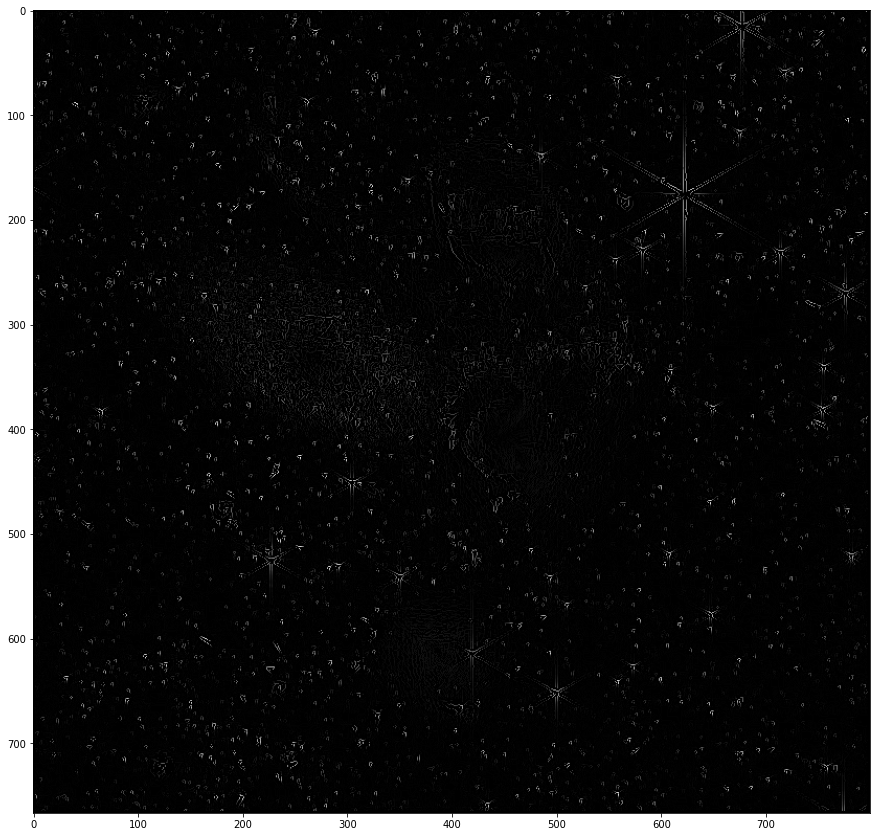

In [35]:
nms_img = non_maximum_suppression(magnitud_img, fase_img)

plt.figure(figsize=(15, 15))
plt.imshow(nms_img, cmap='gray')

In [36]:
def threshold(img, threshold=20):
    alto = img.shape[0]
    ancho = img.shape[1]
    newImg = np.zeros((alto, ancho, 1))

    for i in range(0, alto):
        for j in range(0, ancho):
            if(img[i, j] > threshold):
                newImg[i, j] = 255
            else:
                newImg[i, j] = 0
    return newImg

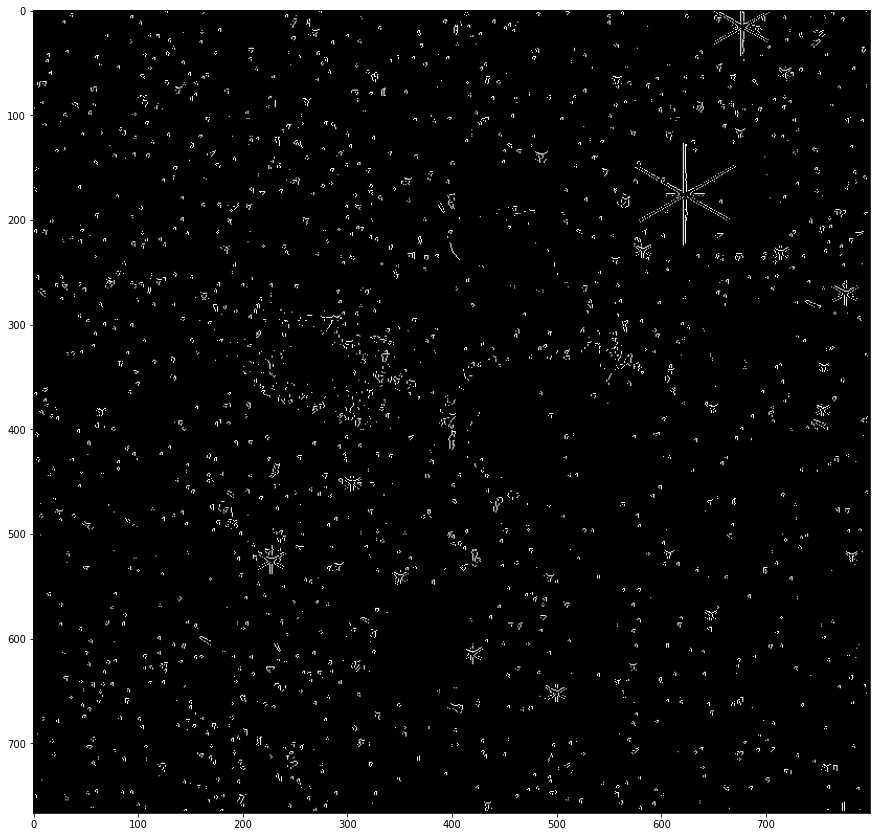

In [37]:
canny = threshold(nms_img)

plt.figure(figsize=(15, 15))
plt.imshow(canny, cmap='gray')

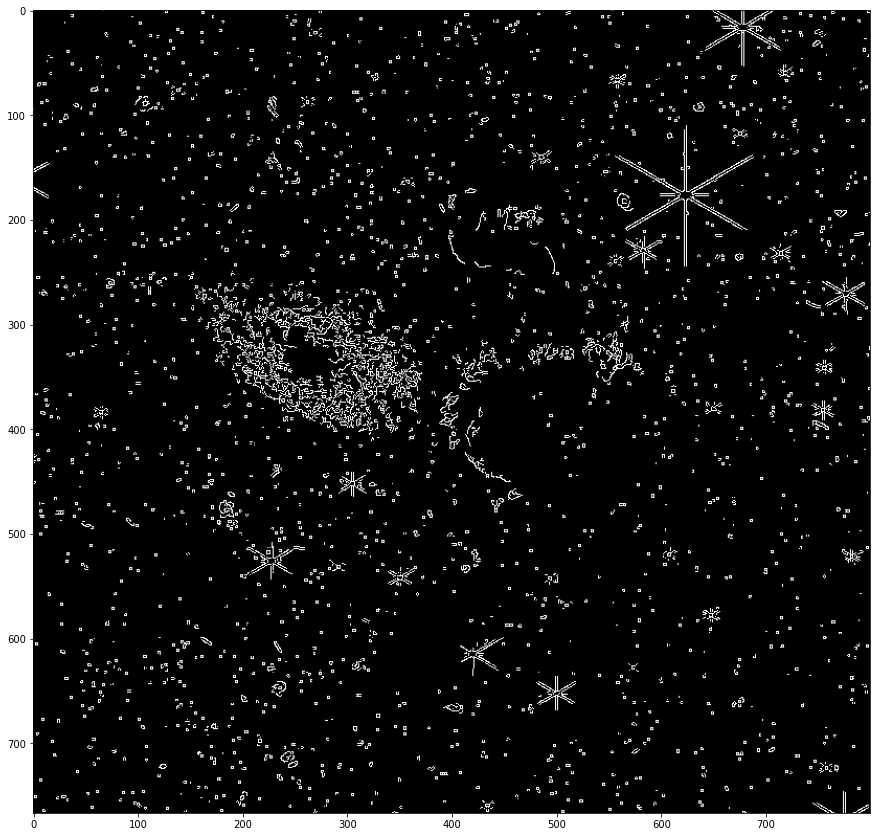

In [43]:
# comparemos con opencv
edges = cv2.Canny(img, 100, 200)

plt.figure(figsize=(15, 15))
plt.imshow(edges, cmap='gray')